# prettier-graphs

This example demonstrates the `prettier_graphs` function.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define Strategy Class - sell in my and go away

In [4]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        
        self.ts = None
        self.rlog = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            end_flag = pf.is_last_row(self.ts, i)

            # Buy (at the close on first trading day in Nov).
            if self.tlog.shares == 0:
                if row.month == 11 and row.first_dotm:
                    self.tlog.buy(date, row.close)
            # Sell (at the close on first trading day in May).
            else:
                if ((row.month == 5 and row.first_dotm) or end_flag):
                    self.tlog.sell(date, row.close)

            # Record daily balance
            self.dbal.append(date, row.close)

    def run(self):
        
        # Fetch and select timeseries.
        self.ts = pf.fetch_timeseries(self.symbol)
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end,
                                        use_adj=True)
        # Add calendar columns.
        self.ts = pf.calendar(self.ts)
        
        # Finalize timeseries.
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start,
                                                     dropna=True, drop_columns=['open', 'high', 'low'])
        
        # Create tlog and dbal objects
        self.tlog = pf.TradeLog(symbol)
        self.dbal = pf.DailyBal()
        
        # Run algorithm, get logs
        self._algo()
        self._get_logs()
        self._get_stats()

    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        s.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [5]:
s = Strategy(symbol, capital, start, end)
s.run()

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [6]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

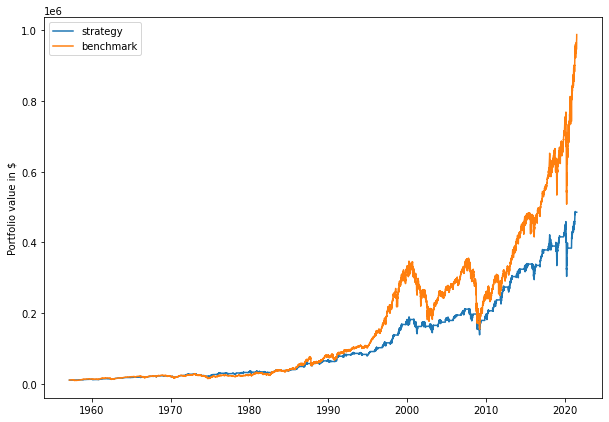

In [7]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.22,7.40
max_closed_out_drawdown,-34.96,-56.78
annualized_return_over_max_drawdown,0.18,0.13
best_month,23.36,23.49
worst_month,-30.85,-30.94
sharpe_ratio,0.60,0.53
sortino_ratio,0.55,0.67
monthly_std,2.93,4.28
annual_std,9.89,15.85


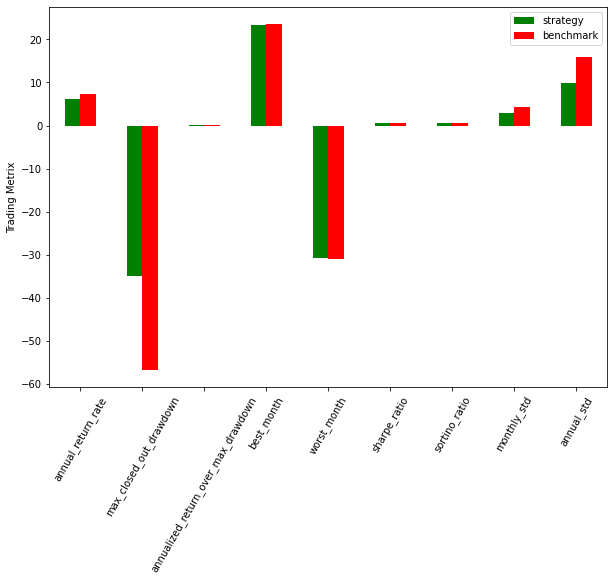

In [8]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df

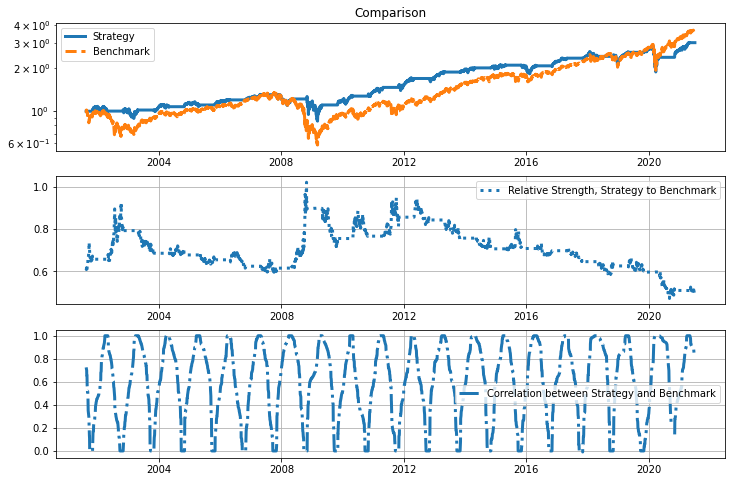

In [9]:
dbal = s.dbal['close']
benchmark_dbal = benchmark.dbal['close']

pf.prettier_graphs(dbal, benchmark_dbal, points_to_plot=5000)